In [1]:
from operator import mod
from tomo2mesh.misc.voxel_processing import TimerGPU, edge_map, modified_autocontrast, get_values_cyl_mask, cylindrical_mask, TimerCPU
from tomo2mesh.projects.eaton.recon import recon_binned, recon_all
from tomo2mesh.structures.patches import Patches
import cupy as cp
import numpy as np
import pandas as pd
from tomo2mesh.structures.voids import Voids
from skimage.filters import threshold_otsu
from cupyx.scipy import ndimage
from scipy import ndimage as ndimage_cpu
import cc3d
import matplotlib.pyplot as plt
from tomo2mesh.projects.eaton.rw_utils_ae import read_raw_data_1X
from tomo2mesh import viewer

In [2]:
projs, theta, center, dark, flat = read_raw_data_1X("1", "124")
b = 1
pixel_size = 3.13
z_crop = (1536//2, 1536)

In [3]:
timer = TimerCPU("secs")

# tmp_path = '/data01/Eaton_Polymer_AM/reconstructed/tmp_rec'
#Reconstruction
t_gpu = TimerGPU("secs")
memory_pool = cp.cuda.MemoryPool()
cp.cuda.set_allocator(memory_pool.malloc)

ntheta, nz, n = projs.shape
projs = np.mean(projs.reshape(ntheta,nz//b,b,n//b,b), axis = (2,4))
projs = np.array(projs, dtype = np.float32)
dark = np.mean(dark.reshape(nz//b, b, n//b, b), axis = (1,3))
flat = np.mean(flat.reshape(nz//b, b, n//b, b), axis = (1,3))
dark = np.array(dark.astype(np.float32), dtype = np.float32)
flat = np.array(flat.astype(np.float32), dtype = np.float32)
theta = np.array(theta, dtype = np.float32)
center = np.float32(center/float(b))

In [4]:
#FBP
t_gpu.tic()
V = recon_all(projs, theta, center, 32, dark, flat, pixel_size) 
V_rec = V #[:(nz//28)*28,:(n//28)*28,:(n//28)*28] 

t_rec = t_gpu.toc('RECONSTRUCTION')

100%|███████████████████████████████████████████| 48/48 [02:13<00:00,  2.78s/it]

	TIME: RECONSTRUCTION 133.26 secs


In [5]:
memory_pool.free_all_blocks()

In [6]:
timer = TimerCPU("secs")
timer.tic()
p_size = 144
patches = Patches(V_rec.shape, initialize_by = "bestfit_grid", patch_size = (p_size,p_size,p_size))
x_vols = patches.extract(V_rec, (p_size,p_size,p_size))
timer.toc("Create patches")

timer.tic()
thresh_list = []
for i in range(len(x_vols)):
    thresh_list.append((x_vols[i]<threshold_otsu(x_vols[i][::3,::3,::3])).astype(np.uint8))
timer.toc("Create thresh list")

timer = TimerCPU("secs")
timer.tic()
V_seg = np.empty(V_rec.shape, dtype = np.uint8)
patches.fill_patches_in_volume(thresh_list, V_seg)
V_seg = V_seg[slice(z_crop[0]//b, z_crop[1]//b),...]
timer.toc("Fill patches")

	TIME: Create patches 10.23 secs
	TIME: Create thresh list 11.20 secs
	TIME: Fill patches 2.84 secs


2.8449134826660156

In [7]:
# Connected components
cylindrical_mask(V_seg, 1, mask_val = 0)
V_seg = cc3d.connected_components(V_seg)

# Porosity without dust removal
porosity = (np.sum((V_seg>0).astype(np.uint8)))/(np.prod(V_seg.shape)*np.pi/4)
print("Porosity:", porosity)

timer.tic()
voids_b = Voids().count_voids(V_seg, b, 0)

Porosity: 0.127628905524278
	STAT: voids found - 151678


In [8]:
V_seg = np.zeros(voids_b.vol_shape, dtype=np.uint8)
for iv, s_void in enumerate(voids_b["s_voids"]):
    V_seg[s_void] += voids_b["x_voids"][iv].copy()

<AxesSubplot:>

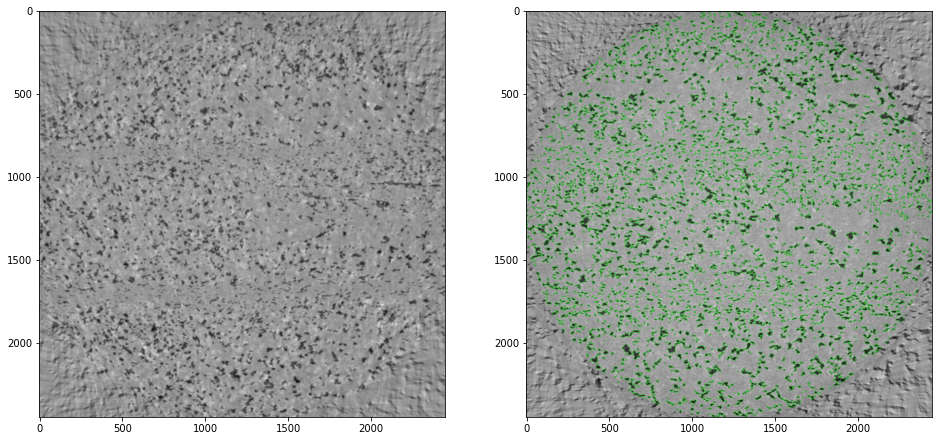

In [9]:
img = V_rec[1536//2+50]
img_bin = V_seg[50]
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].imshow(V_rec[1536//2], cmap = 'gray')
viewer.edge_plot(img, img_bin, ax[1])

In [ ]:
# cylindrical_mask(V_rec, 1, mask_val = V_rec[::4,::4,::4].min())